## Dependencies

In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from models import CNN, build_resnet
from gaf import GAF
from train import train_model
import os
from pathlib import Path
from utils import ECGDataset, plot_loss_curves, plot_gaf_samples,plot_gaf_both
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler

torch.manual_seed(42)
os.makedirs('./logs/',exist_ok=True)
os.makedirs('./saved_models',exist_ok=True)

# Model 1: CNN - GASF
log_path_1 = Path('./logs/cnn_gasf.csv')
model_path_1 = Path('./saved_models/cnn_gasf.pt')

# Model 2: CNN - GADF
log_path_2 = Path('./logs/cnn_gadf.csv')
model_path_2 = Path('./saved_models/cnn_gadf.pt')

# Model 3: CNN - GASF + GADF
log_path_3 = Path('./logs/cnn_both.csv')
model_path_3 = Path('./saved_models/cnn_both.pt')

# Model 4: ResNet - GASF + GADF
log_path_4 = Path('./logs/resnet_both.csv')
model_path_4 = Path('./saved_models/resnet_both.pt')

# Parameters
BATCH_SIZE=32
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Load Dataset

In [2]:
# Load datasets
train_data = pd.read_csv('../data/ecg_signals/mitbih_train.csv', header=None)
test_data = pd.read_csv('../data/ecg_signals/mitbih_test.csv', header=None)

# Extract features and labels
X = train_data.iloc[:, :-1].values
y = train_data.iloc[:, -1].astype(int).values

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,stratify=y,shuffle=True,random_state=42)

rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)

# Load test set
X_test = test_data.iloc[:, :-1].values
y_test = test_data.iloc[:, -1].astype(int).values

C:\Users\harsh\AppData\Local\Temp\ipykernel_18892\663069994.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_mapping.values()), y=counts, palette="viridis")


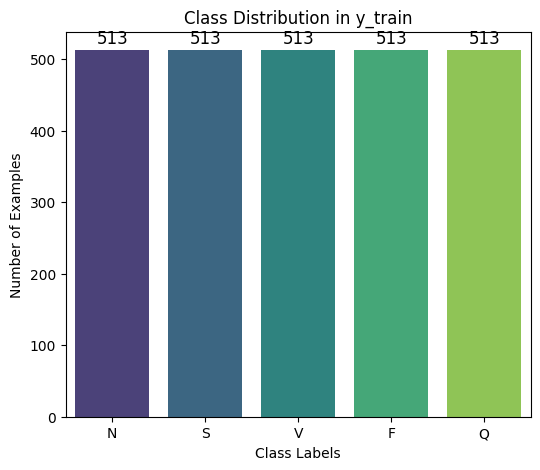

In [3]:
# Class label mapping
class_mapping = {0: 'N', 1: 'S', 2: 'V', 3: 'F', 4: 'Q'}

# Count occurrences of each class
unique_classes, counts = np.unique(y_train, return_counts=True)


# Plot class distribution
plt.figure(figsize=(6, 5))
sns.barplot(x=list(class_mapping.values()), y=counts, palette="viridis")

# Add labels
plt.xlabel("Class Labels")
plt.ylabel("Number of Examples")
plt.title("Class Distribution in y_train")

# Show values on bars
for i, count in enumerate(counts):
    plt.text(i, count + 10, str(count), ha='center', fontsize=12)

plt.show()

## Exploratory Data Analysis

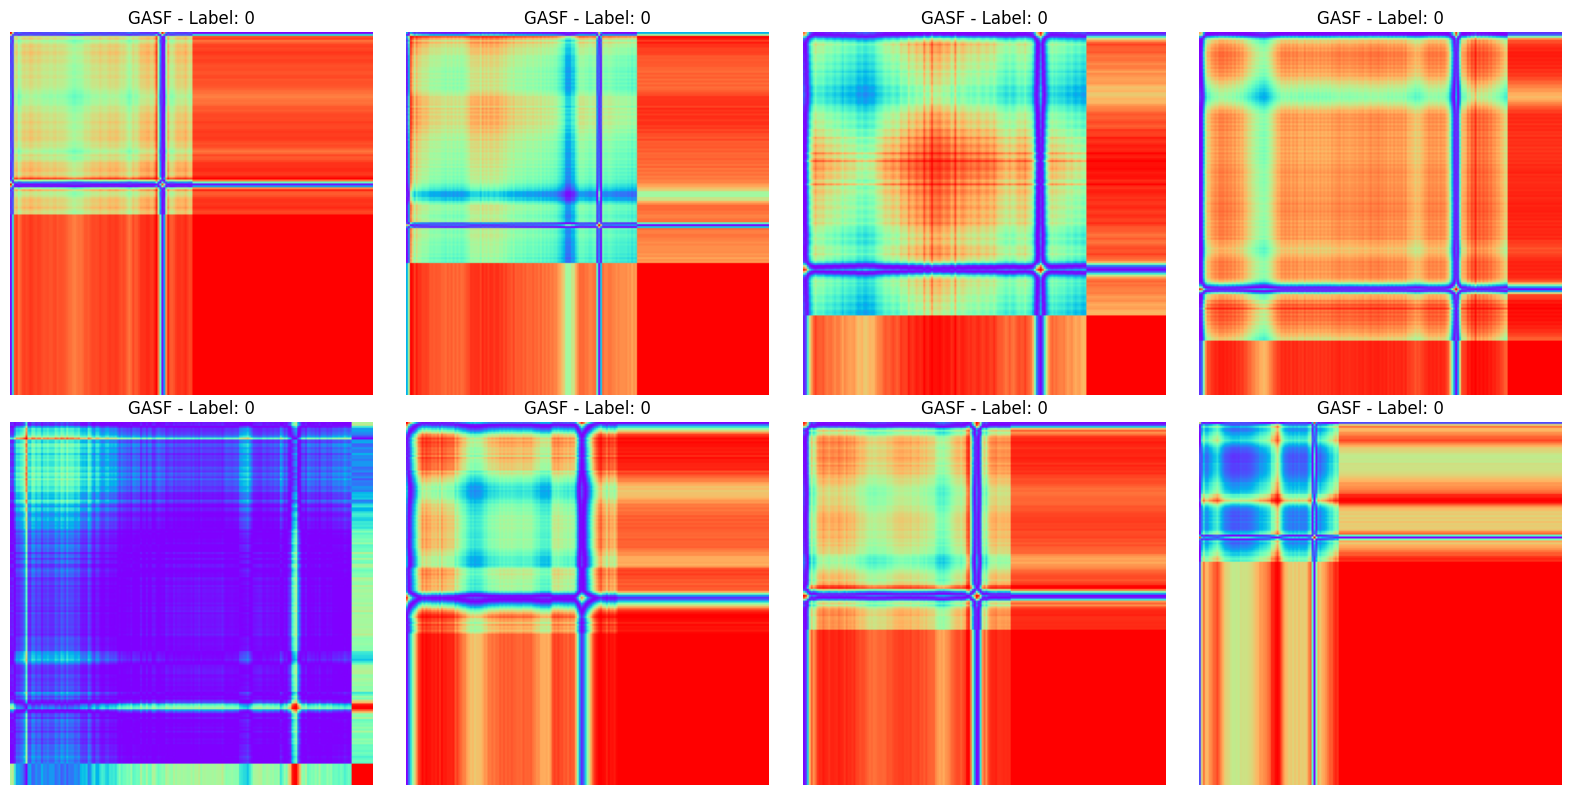

In [4]:
train_dataset_gasf = ECGDataset(X_train, y_train,gaf_mode='gasf')

plot_gaf_samples(dataset=train_dataset_gasf,num_samples=8,cols=4)


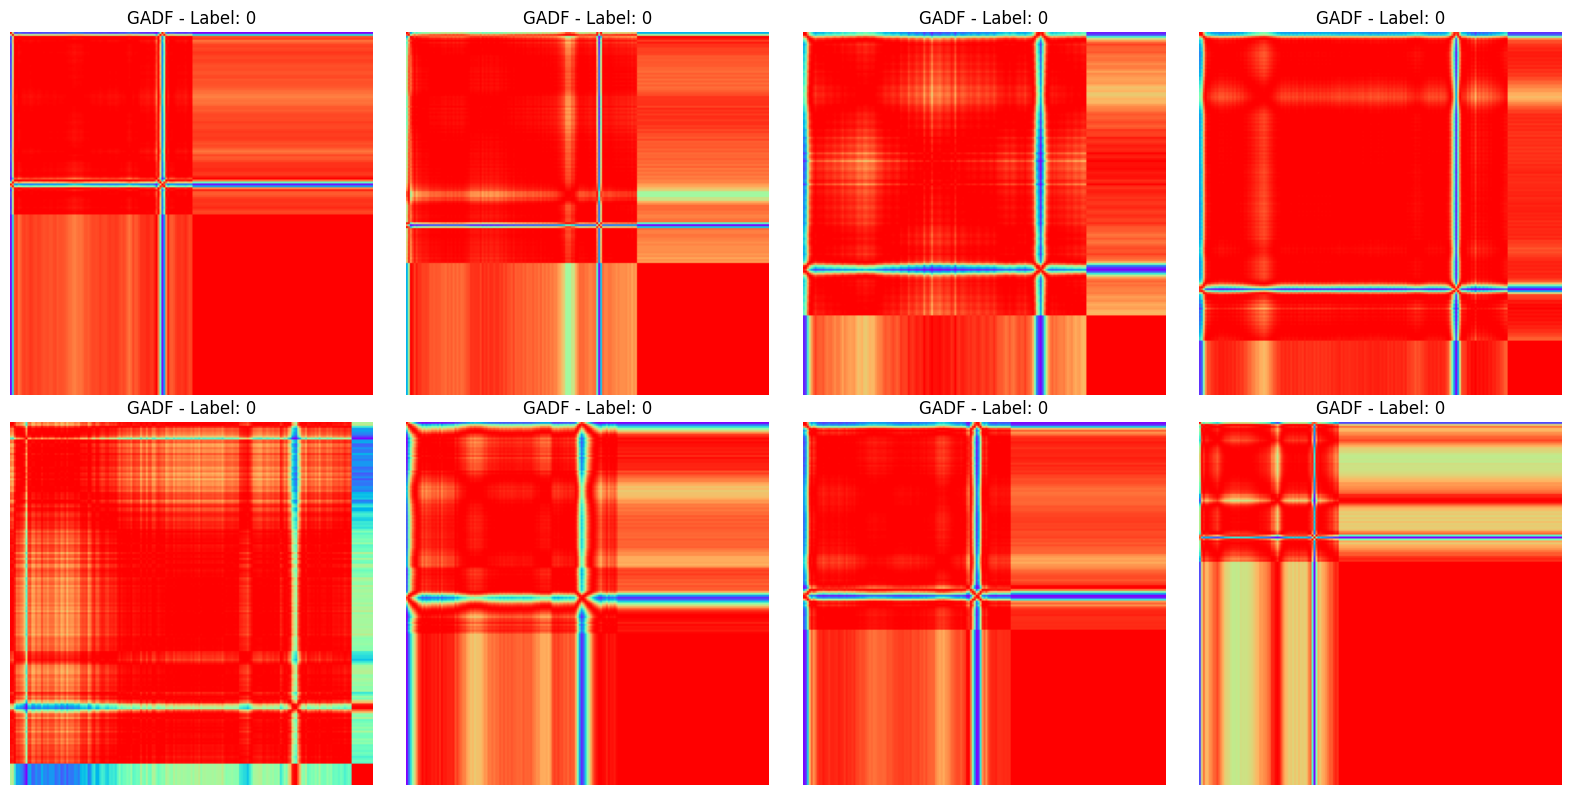

In [5]:
train_dataset_gadf = ECGDataset(signals=X_train,labels=y_train,gaf_mode='gadf')
plot_gaf_samples(dataset=train_dataset_gadf,num_samples=8,cols=4,gaf_type='GADF')

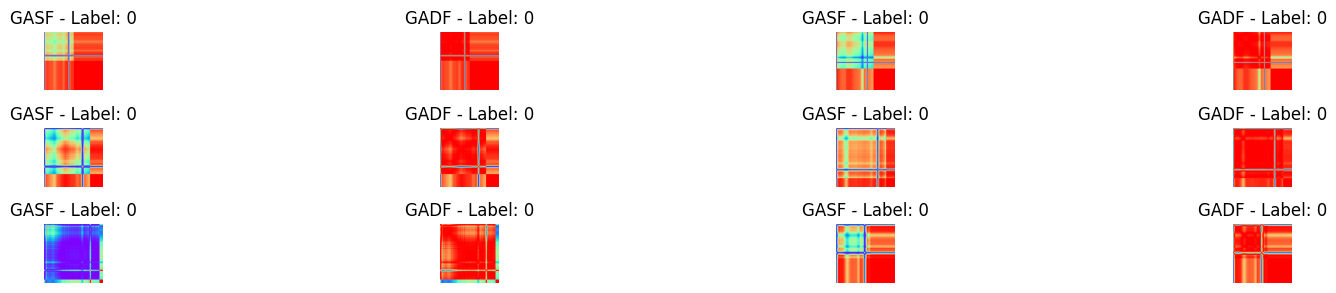

In [6]:
train_dataset_both = ECGDataset(signals=X_train,labels=y_train)
plot_gaf_both(dataset=train_dataset_both,num_samples=6,cols=4,gaf_type='GASF + GADF')

## Model 1 - CNN - GASF

In [7]:
train_dataset = ECGDataset(signals=X_train,
                           labels=y_train,
                           gaf_mode='gasf')
val_dataset = ECGDataset(signals=X_val,
                         labels=y_val,
                         gaf_mode='gasf')
test_dataset = ECGDataset(signals=X_test,
                          labels=y_test,
                          gaf_mode='gasf')

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=BATCH_SIZE)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE)


model_1 = CNN()
train_model(model=model_1,
            train_loader=train_loader,
            val_loader=val_loader,
            device=device,
            num_epochs=50,
            log_path=log_path_1,
            model_path=model_path_1,
            patience=10)

Epoch 1/50 | Train Loss: 0.8310 | Train Acc: 0.6936 | Val Loss: 0.7623 | Val Acc: 0.7233 | Patience: 0
Epoch 2/50 | Train Loss: 0.5298 | Train Acc: 0.8074 | Val Loss: 0.8929 | Val Acc: 0.6503 | Patience: 0
Epoch 3/50 | Train Loss: 0.3983 | Train Acc: 0.8538 | Val Loss: 0.5034 | Val Acc: 0.8250 | Patience: 1
Epoch 4/50 | Train Loss: 0.3235 | Train Acc: 0.8893 | Val Loss: 0.5500 | Val Acc: 0.7996 | Patience: 0
Epoch 5/50 | Train Loss: 0.2674 | Train Acc: 0.9006 | Val Loss: 0.4096 | Val Acc: 0.8482 | Patience: 1
Epoch 6/50 | Train Loss: 0.2050 | Train Acc: 0.9248 | Val Loss: 0.6348 | Val Acc: 0.7842 | Patience: 0
Epoch 7/50 | Train Loss: 0.1734 | Train Acc: 0.9388 | Val Loss: 0.6041 | Val Acc: 0.7947 | Patience: 1
Epoch 8/50 | Train Loss: 0.1322 | Train Acc: 0.9520 | Val Loss: 0.5423 | Val Acc: 0.8230 | Patience: 2
Epoch 9/50 | Train Loss: 0.1051 | Train Acc: 0.9626 | Val Loss: 0.5592 | Val Acc: 0.8390 | Patience: 3
Epoch 10/50 | Train Loss: 0.0938 | Train Acc: 0.9676 | Val Loss: 0.4399 |

## Model 2: CNN - GADF

In [ ]:
train_dataset = ECGDataset(signals=X_train,
                           labels=y_train,
                           gaf_mode='gadf')
val_dataset = ECGDataset(signals=X_val,
                         labels=y_val,
                         gaf_mode='gadf')
test_dataset = ECGDataset(signals=X_test,
                          labels=y_test,
                          gaf_mode='gadf')

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=BATCH_SIZE)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE)


model_2 = CNN()
# train_model(model=model_2,
#             train_loader=train_loader,
#             val_loader=val_loader,
#             device=device,
#             num_epochs=50,
#             log_path=log_path_2,
#             model_path=model_path_2,
#             patience=10)

Epoch 1/50 | Train Loss: 0.9181 | Train Acc: 0.6456 | Val Loss: 1.0482 | Val Acc: 0.5346 | Patience: 0
Epoch 2/50 | Train Loss: 0.5191 | Train Acc: 0.8195 | Val Loss: 0.3235 | Val Acc: 0.9067 | Patience: 0
Epoch 3/50 | Train Loss: 0.4430 | Train Acc: 0.8394 | Val Loss: 0.5974 | Val Acc: 0.7818 | Patience: 0
Epoch 4/50 | Train Loss: 0.3634 | Train Acc: 0.8651 | Val Loss: 0.7128 | Val Acc: 0.7462 | Patience: 1
Epoch 5/50 | Train Loss: 0.3112 | Train Acc: 0.8889 | Val Loss: 0.7127 | Val Acc: 0.7435 | Patience: 2
Epoch 6/50 | Train Loss: 0.2808 | Train Acc: 0.8975 | Val Loss: 0.5741 | Val Acc: 0.7932 | Patience: 3
Epoch 7/50 | Train Loss: 0.2418 | Train Acc: 0.9060 | Val Loss: 0.3313 | Val Acc: 0.8862 | Patience: 4
Epoch 8/50 | Train Loss: 0.2258 | Train Acc: 0.9111 | Val Loss: 0.4541 | Val Acc: 0.8443 | Patience: 5
Epoch 9/50 | Train Loss: 0.1712 | Train Acc: 0.9345 | Val Loss: 0.3934 | Val Acc: 0.8727 | Patience: 6
Epoch 10/50 | Train Loss: 0.1545 | Train Acc: 0.9415 | Val Loss: 0.4594 |

In [ ]:
plot_loss_curves(log_path=log_path_2,suptitle='CNN - GADF')

## Model 3: CNN - both

In [ ]:
# train_dataset = ECGDataset(signals=X_train,
#                            labels=y_train,
#                            gaf_mode='both')
# val_dataset = ECGDataset(signals=X_val,
#                          labels=y_val,
#                          gaf_mode='both')
# test_dataset = ECGDataset(signals=X_test,
#                           labels=y_test,
#                           gaf_mode='both')

# train_loader = DataLoader(dataset=train_dataset,
#                           batch_size=BATCH_SIZE,
#                           shuffle=True)
# val_loader = DataLoader(dataset=val_dataset,
#                         batch_size=BATCH_SIZE)
# test_loader = DataLoader(dataset=test_dataset,
#                          batch_size=BATCH_SIZE)


# model_3 = CNN(in_channels=2)
# train_model(model=model_3,
#             train_loader=train_loader,
#             val_loader=val_loader,
#             device=device,
#             num_epochs=50,
#             log_path=log_path_3,
#             model_path=model_path_3,
#             patience=10)

Epoch 1/50 | Train Loss: 0.8623 | Train Acc: 0.6713 | Val Loss: 0.8349 | Val Acc: 0.7187 | Patience: 0
Epoch 2/50 | Train Loss: 0.5644 | Train Acc: 0.7996 | Val Loss: 0.7252 | Val Acc: 0.7462 | Patience: 0
Epoch 3/50 | Train Loss: 0.4600 | Train Acc: 0.8324 | Val Loss: 0.4960 | Val Acc: 0.8386 | Patience: 0
Epoch 4/50 | Train Loss: 0.3694 | Train Acc: 0.8655 | Val Loss: 0.3671 | Val Acc: 0.8932 | Patience: 0
Epoch 5/50 | Train Loss: 0.3122 | Train Acc: 0.8838 | Val Loss: 0.5388 | Val Acc: 0.8161 | Patience: 0
Epoch 6/50 | Train Loss: 0.2972 | Train Acc: 0.8932 | Val Loss: 0.4868 | Val Acc: 0.8326 | Patience: 1
Epoch 7/50 | Train Loss: 0.2312 | Train Acc: 0.9135 | Val Loss: 0.5926 | Val Acc: 0.7899 | Patience: 2
Epoch 8/50 | Train Loss: 0.1876 | Train Acc: 0.9287 | Val Loss: 0.4454 | Val Acc: 0.8501 | Patience: 3
Epoch 9/50 | Train Loss: 0.1657 | Train Acc: 0.9388 | Val Loss: 0.4990 | Val Acc: 0.8425 | Patience: 4
Epoch 10/50 | Train Loss: 0.1329 | Train Acc: 0.9520 | Val Loss: 0.4623 |

## Model 4: ResNet - both

In [10]:
train_dataset = ECGDataset(signals=X_train,
                           labels=y_train,
                           gaf_mode='both')
val_dataset = ECGDataset(signals=X_val,
                         labels=y_val,
                         gaf_mode='both')
test_dataset = ECGDataset(signals=X_test,
                          labels=y_test,
                          gaf_mode='both')

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=BATCH_SIZE)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE)


model_4 = build_resnet(in_channels=2)
train_model(model=model_4,
            train_loader=train_loader,
            val_loader=val_loader,
            device=device,
            num_epochs=50,
            log_path=log_path_4,
            model_path=model_path_4,
            patience=10)

c:\Projects\python\algorithms\mainenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Projects\python\algorithms\mainenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50 | Train Loss: 0.6819 | Train Acc: 0.7618 | Val Loss: 0.4803 | Val Acc: 0.8456 | Patience: 0
Epoch 2/50 | Train Loss: 0.4359 | Train Acc: 0.8491 | Val Loss: 0.7225 | Val Acc: 0.7457 | Patience: 0
Epoch 3/50 | Train Loss: 0.3853 | Train Acc: 0.8678 | Val Loss: 0.9103 | Val Acc: 0.6956 | Patience: 1
Epoch 4/50 | Train Loss: 0.4077 | Train Acc: 0.8487 | Val Loss: 0.5125 | Val Acc: 0.8321 | Patience: 2
Epoch 5/50 | Train Loss: 0.3386 | Train Acc: 0.8772 | Val Loss: 0.7200 | Val Acc: 0.7402 | Patience: 3
Epoch 6/50 | Train Loss: 0.2979 | Train Acc: 0.8897 | Val Loss: 0.8832 | Val Acc: 0.6748 | Patience: 4
Epoch 7/50 | Train Loss: 0.3358 | Train Acc: 0.8780 | Val Loss: 0.2663 | Val Acc: 0.9185 | Patience: 5
Epoch 8/50 | Train Loss: 0.2984 | Train Acc: 0.8951 | Val Loss: 0.5511 | Val Acc: 0.8034 | Patience: 0
Epoch 9/50 | Train Loss: 0.2265 | Train Acc: 0.9177 | Val Loss: 0.6278 | Val Acc: 0.7186 | Patience: 1
Epoch 10/50 | Train Loss: 0.2441 | Train Acc: 0.9135 | Val Loss: 0.2178 |